# VoxCeleb 1 benchmark

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from deciphering_enigma.settings import _MODELS_WEIGHTS

In [ ]:
import matplotlib
from pylab import cm
import matplotlib as mpl
matplotlib.font_manager._fmcache
matplotlib.font_manager._rebuild()
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 3

In [4]:
from glob import glob
files = glob('/om2/user/gelbanna/voxceleb_1/*/*.csv')
dfs = []
for file in files:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs)
df['Score'] *= 100

## Dataset:
In this section, we benchmarked all handcrafted and self-supervised models against an automatic speaker recognition (ASpR) task. VoxCeleb 1 (VC1) [[1](https://arxiv.org/pdf/1706.08612.pdf)] is used as a large-scale speaker recognition dataset. VC1 comprises 153,514 utterances from 1,251 speakers/celebrities with average duration of 8.2s. These utterances were compiled from YouTube videos with diverse acoustic environments, then, converted to single-channel audio stream with sampling rate of 16kHz. For the benchmark, the dataset is divided into three splits; train, validation and test sets. We followed the splits provided on their [website](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html) in which we have 138,361, 6,904 and 8,251 utterances, respectively.

## Evaluation Details:
The benchmark evaluation was adapted from [[2](https://arxiv.org/pdf/2204.07402.pdf)] with their [code](https://github.com/nttcslab/byol-a) implementation, then, modified to follow our feature extraction implementation. The evaluation pipeline includes extracting the features of VC1 utterances from each model (handcrfated or self-supervised). The features of each utterance is temporally pooled using *mean+max* to generate 1D vector per sample. Then, we trained a single linear layer classifier with 100 nodes to fit the features from the train set of VC1 using adam optimizer and test the validation set for early stopping with patience of 10 epochs. The classifier trains for 200 epochs with learning being tuned to optimize the results on the validation set between 0.0001 to 0.01, we manually checked lower values that yielded worst results. The features were standardized before training the linear classifier. We ran this process three times for each model and reported the *unweighted average recall* (UAR) percentage to account for the unbalanced labels in the dataset. We used *scikit-learn* package to benchmark the downstream task.

## Evaluation Results:

### 1) VoxCeleb1 Benchmark

In the Figure below, we reported the average UAR percentage for each model with 95% confidence interval.

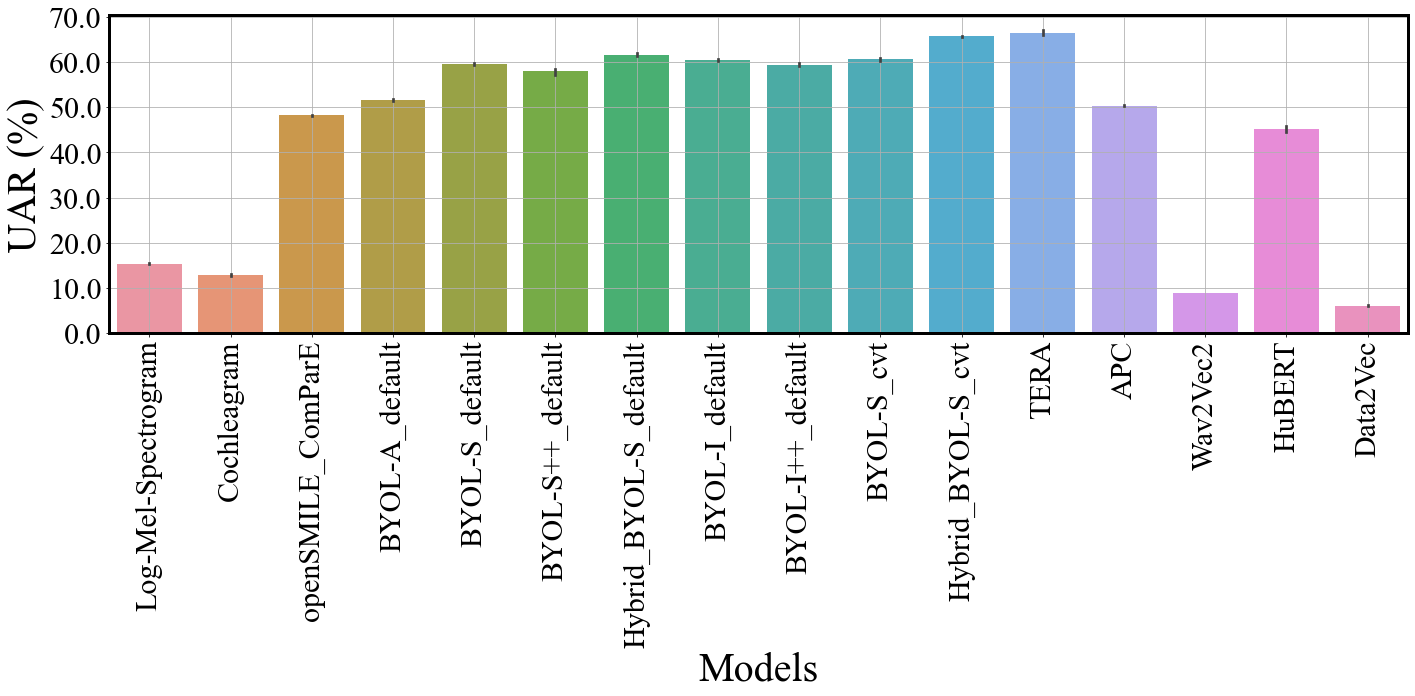

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
order = ['Log-Mel-Spectrogram', 'Cochleagram', 'openSMILE_ComParE', 'BYOL-A_default', 'BYOL-S_default', 'BYOL-S++_default', 'Hybrid_BYOL-S_default', 
'BYOL-I_default', 'BYOL-I++_default', 'BYOL-S_cvt', 'Hybrid_BYOL-S_cvt', 'TERA', 'APC', 'Wav2Vec2', 'HuBERT', 'Data2Vec']
sns.barplot(data=df, x='Model', y='Score', ax=ax, order=order)
ax.set_xticklabels(ax.get_xticklabels(), size = 30, rotation=90)
ax.set_yticklabels(ax.get_yticks(), size = 30)
ax.set_ylabel('UAR (%)', fontsize=40)
ax.set_xlabel('Models', fontsize=40)
plt.grid()
plt.tight_layout()

### 2) Layer-wise Analysis

To thoroughly examine a model's performance, evaluating the intermediate representations across layers might elucidate the model's best layer for a downstream task. Moreover, the three models (Wav2Vec2, HuBERT and Data2Vec) share similar architectural structures comprising layers of CNN followed by layers of transformers. Thus, as shown in Figure below, we also benchmarked the performance of the latent features generated from the last CNN layer in these models and the contextual features generated from the last transformer layer which happens to be the features examined in the Figure above. Additionally, we reported the performance of the best layer for Wav2Vec2, HuBERT and Data2Vec which happens to be transformer layer 4, 7 and 3, respectively. 


![latent_contextual_figure.png](latent_contextual_figure.png)

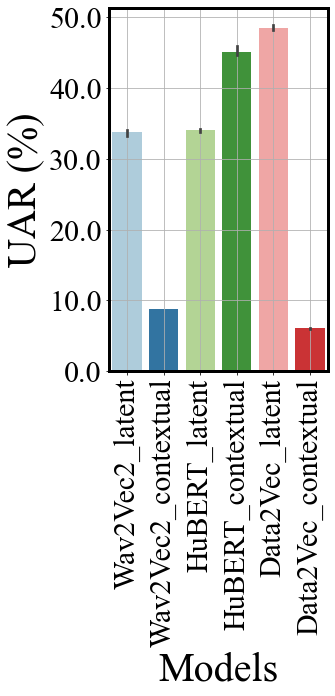

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
order=['Wav2Vec2_latent', 'Wav2Vec2', 'HuBERT_latent', 'HuBERT', 'Data2Vec_latent', 'Data2Vec']
sns.barplot(data=df, x='Model', y='Score', ax=ax, order=order, palette="Paired")
ax.set_xticklabels(['Wav2Vec2_latent', 'Wav2Vec2_contextual', 'HuBERT_latent', 'HuBERT_contextual', 'Data2Vec_latent', 'Data2Vec_contextual'], size = 30, rotation=90)
ax.set_yticklabels(ax.get_yticks(), size = 30)
ax.set_ylabel('UAR (%)', fontsize=40)
ax.set_xlabel('Models', fontsize=40)
plt.grid()
plt.tight_layout()

We further explored all layers in of Wav2Vec2, HuBERT and Data2Vec to showcase the variation of speaker identity information across layers. We sampled randomly 100 speakers, gender-balanced, from VC1 dataset and followed the same linear evaluation pipeline explained above to recognize, in this case, 100 speakers. We ran the linear evaluation once on each layer. As illustrated in the Figure below, we reported the UAR percentage of each layer embeddings for the three models. Both Wav2Vec2 and Data2Vec share the same architecture, whereas, HuBERT has more transformer layers, as shown below.

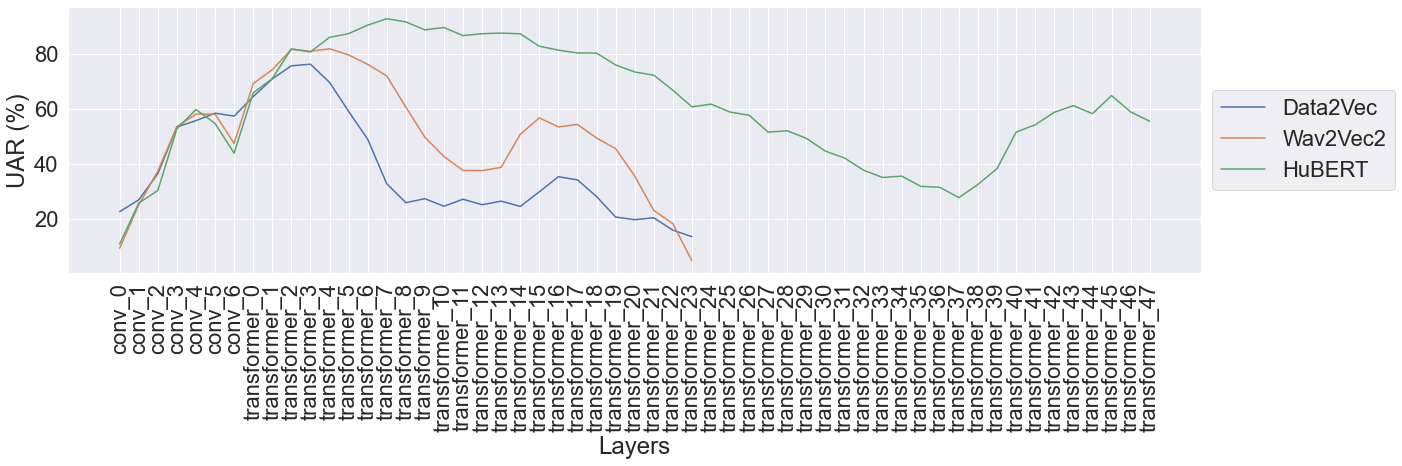

In [ ]:
sns.set(font_scale=2)
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
line = sns.lineplot(data=df, x='Layer_name', y='Score', hue='Model', ax=ax)
ax.set_xticks(df.Layer_name.unique())
ax.set_xticklabels(df.Layer_name.unique(), rotation=90)
ax.set_ylabel('UAR (%)')
ax.set_xlabel('Layers')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

### 3) Number of Speakers

As humans capacity to recognize a number of speakers to identitfy is limited to memory. Similarly, one might argue that models' performance would deteriorate as we scale up the number of speakers. Accordingly, we evaluated the performance of all models on different number of speakers ranging from 10 to 1000 speakers. We made sure to sample gender-balanced subsets of speakers randomly as we increment to avoid speaker-bias. The linear evaluation is similar to the benchmark except that the training occurs once per model instead of three times.

As shown in the Figure below, the UAR is reported as a function of number of speakers for each model.

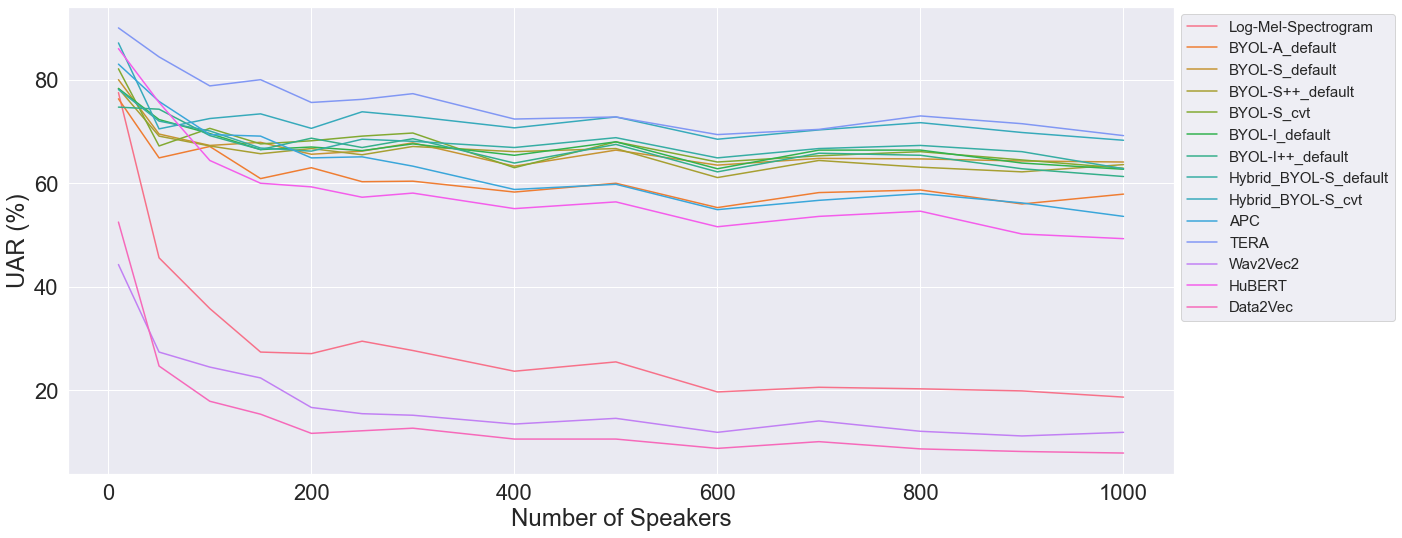

In [25]:
#increase font size of all elements
sns.set(font_scale=2)
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
line = sns.lineplot(data=df, x='Num_Speakers', y='Scores', hue='Models', ax=ax, hue_order=models_order)
ax.set_ylabel('UAR (%)')
ax.set_xlabel('Number of Speakers')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=15)
plt.tight_layout()

## Discussion:
Based on the reported Figures, it is observed that *TERA* and *Hybrid BYOL-S/CvT* are the best performing self-supervised models in a ASpR task. Surprisingly, the performance of the final layers of *Wav2Vec2*, *HuBERT* and *Data2Vec* is worse than a handcrafted model as openSMILE_ComParE. Accordingly, we explored all layers in these models and found that the intermediate layers generate representations that maximize speaker identity information relatively to the final and latent representations. One might hypothesis that the poor performance of the final layers is due to the models' training protocol. These models were originally pretrained to predict masked speech units. That being said, optimizing such task might require losing speaker-related information and maximize language and phonemes representations. It is also interesting to observe the impact of number of speakers on models' performance. We have seen that the performance, for most models, slightly changes after 200 speakers.